In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import re

from utils import import_data, process_data
from kmeans import find_kmeans, plot_kmeans
from pca import find_pc, project_pca, plot_pca
from lowrank import fit_svd

%matplotlib inline

In [2]:
seed = 123
np.random.seed(seed)

In [3]:
df, mx_gdsc, list_drug, list_cell = import_data()

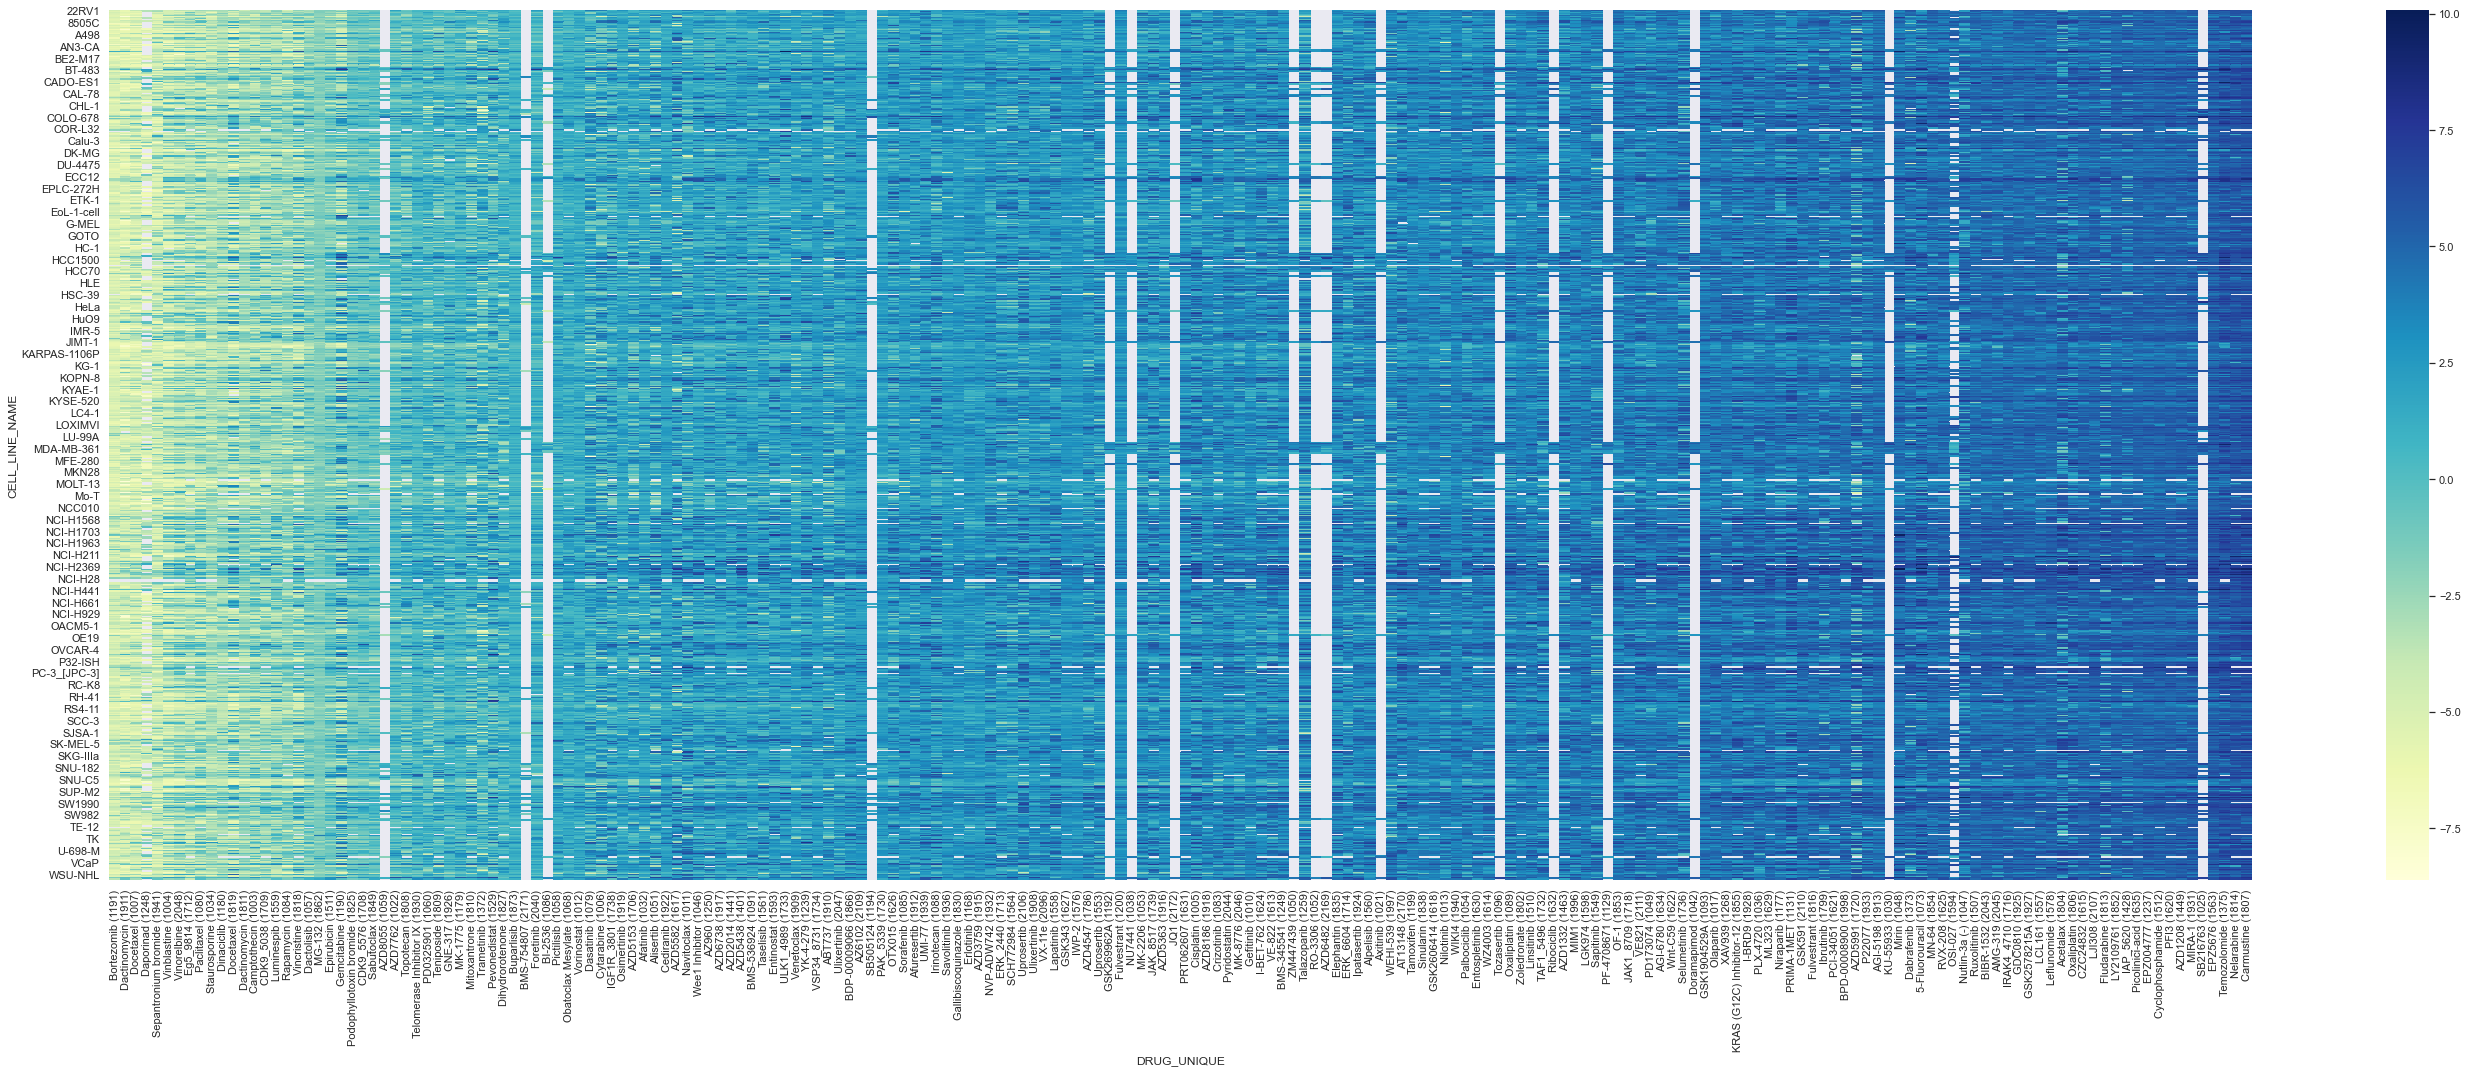

In [4]:
sns.set()
new_dims = (48, 16)
fig, ax = plt.subplots(figsize = new_dims)
ax = sns.heatmap(data = df, cmap="YlGnBu",
                 xticklabels=True);
plt.savefig('plots/heatmap_total.svg')

In [5]:
mx_center, mx_train, idx_val, idx_train, mask_val, mask_train = process_data(mx_gdsc)

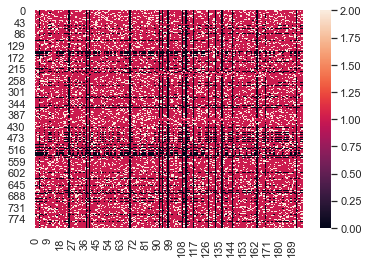

In [6]:
sns.heatmap(mask_train + mask_val * 2);
plt.savefig('plots/heatmap_mask.svg');

# K-Means Clustering on All Data

In [7]:
kmeans_kwargs = {"init": "random",
                 "n_init": 10,
                 "max_iter": 300,
                 "random_state": seed}

kmeans_cell, sse_cell, silhouette_cell = find_kmeans(mx_center, kmeans_kwargs)
kmeans_drug, sse_drug, silhouette_drug = find_kmeans(mx_center.T, kmeans_kwargs)

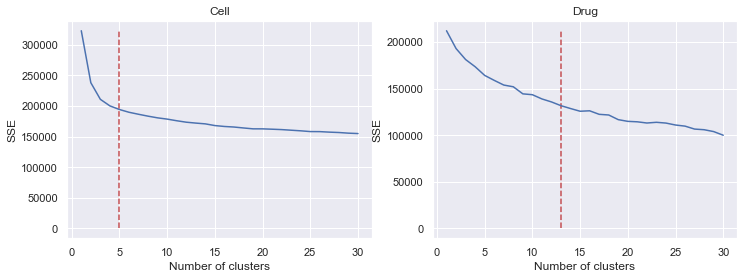

In [8]:
plot_kmeans(kmeans_cell, kmeans_drug, sse_cell, sse_drug, title='knn_total')

# Cluster by PCA

## Cells

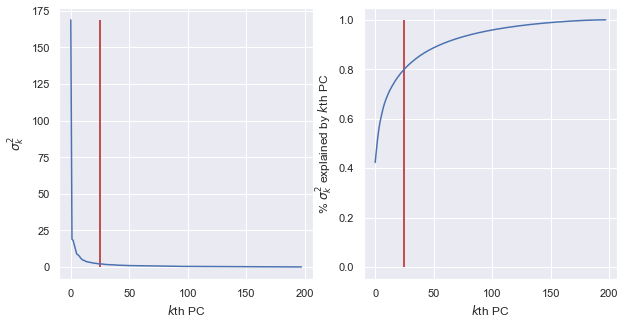

In [9]:
eigenvalues_cell, eigenvectors_cell = find_pc(mx_center)
n_pc_cell = [i for i, j in enumerate(np.cumsum(eigenvalues_cell / np.sum(eigenvalues_cell))) if j > 0.8][0]
plot_pca(eigenvalues_cell, n_pc_cell, title='pca_cell', img_size=(10, 5))

In [10]:
mx_cell_pca2 = project_pca(mx_center, eigenvectors_cell, n_pc=2)
mx_cell_pca = project_pca(mx_center, eigenvectors_cell, n_pc=n_pc_cell)

In [11]:
kmeans_cell_pca, sse_cell_pca, silhouette_cell_pca = find_kmeans(mx_cell_pca, kmeans_kwargs)

## Drug

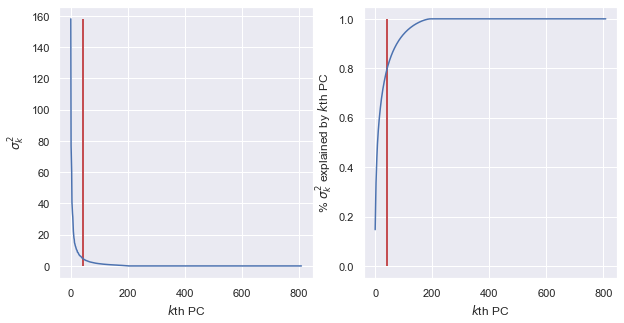

In [13]:
eigenvalues_drug, eigenvectors_drug = find_pc(mx_center.T)
n_pc_drug = [i for i, j in enumerate(np.cumsum(eigenvalues_drug / np.sum(eigenvalues_drug))) if j > 0.8][0]
plot_pca(eigenvalues_drug, n_pc_drug, title='pca_drug', img_size=(10, 5))

In [14]:
mx_drug_pca2 = project_pca(mx_center.T, eigenvectors_drug, n_pc=2)
mx_drug_pca = project_pca(mx_center.T, eigenvectors_drug, n_pc=n_pc_drug)

In [15]:
kmeans_drug_pca, sse_drug_pca, silhouette_drug_pca = find_kmeans(mx_drug_pca, kmeans_kwargs)

## Plots

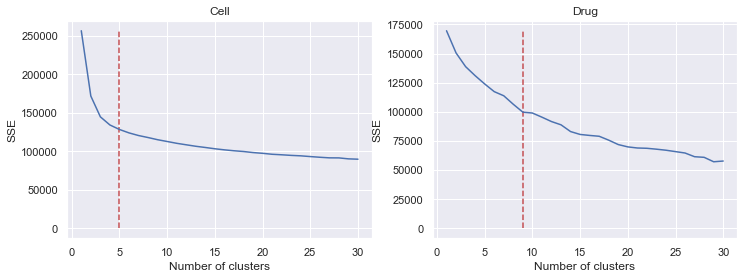

In [16]:
plot_kmeans(kmeans_cell_pca, kmeans_drug_pca, sse_cell_pca, sse_drug_pca, title='knn_pca')

# Low-Rank Model (SVD)

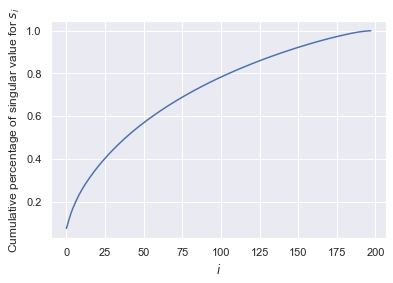

In [17]:
U, s, V = np.linalg.svd(mx_center, full_matrices=False)

plt.plot(range(len(s)), np.cumsum(s / np.sum(s)));
plt.xlabel('$i$');
plt.ylabel('Cumulative percentage of singular value for $s_i$');

In [18]:
ranks = np.arange(1,21,1)
error_train = np.zeros(len(ranks))
error_val = np.zeros(len(ranks))
error_test = np.zeros(len(ranks))
# sing_val = np.zeros((len(ranks), mx_train.shape[1]))

for idx, r in enumerate(ranks):
    print("Rank " + str(r))
    error, estimate, _, s, _ = fit_svd(mx_train, mx_center, idx_train, n_iter=500, rank=r)
    error_train[idx] = error
    error_val[idx] = np.sqrt(np.mean((mx_center.flat[idx_val] - estimate.flat[idx_val])**2))
    # sing_val[idx, :] = s

Rank 1
Rank 2
Rank 3
Rank 4
Rank 5
Rank 6
Rank 7
Rank 8
Rank 9
Rank 10
Rank 11
Rank 12
Rank 13
Rank 14
Rank 15
Rank 16
Rank 17
Rank 18
Rank 19
Rank 20


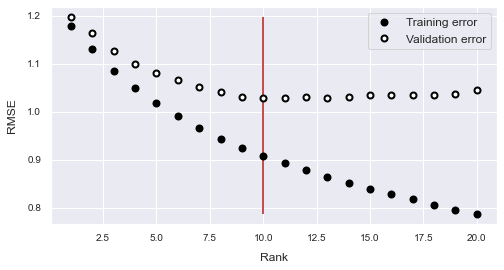

In [19]:
font_size = 12
font_size_ticks = 10
markersize = 6

plt.figure(figsize=(8,4));
plt.plot(ranks,error_train,linestyle="None",marker='o',ms=markersize,color="black",markeredgewidth=2,
         markerfacecolor="black",label="Training error");
plt.plot(ranks,error_val,linestyle="None",marker='o',ms=markersize,color="black",markeredgewidth=2,
         markerfacecolor="white",label="Validation error");
# plt.plot(ranks,error_test,linestyle="None",marker='o',ms=markersize,color="black",markeredgewidth=2,
#          markerfacecolor="red",label="Test error");
plt.vlines(x=np.argmin(error_val)+1, ymin=min(error_train), ymax=max(error_val), 
           colors='r', linestyle='solid', linewidths=2);
plt.ylabel('RMSE',fontsize=font_size,labelpad=10);
plt.xlabel('Rank',fontsize=font_size,labelpad=10);
plt.xticks(fontsize=font_size_ticks);
plt.yticks(fontsize=font_size_ticks);
plt.legend(fontsize=font_size);
plt.savefig('plots/svd_error.svg',bbox_inches="tight")

In [20]:
rank = np.argmin(error_val) + 1
error, estimate, U, s, V = fit_svd(mx_center, mx_center, idx_train, n_iter=100, rank=rank)

mx_cell = U[:,:rank] @ np.diag(np.sqrt(s))[:rank,:rank]
mx_drug = np.diag(np.sqrt(s))[:rank,:rank] @ V[:rank,:]
mx_svd = U[:,:rank] @ np.diag(s)[:rank,:rank] @ V[:rank,:]

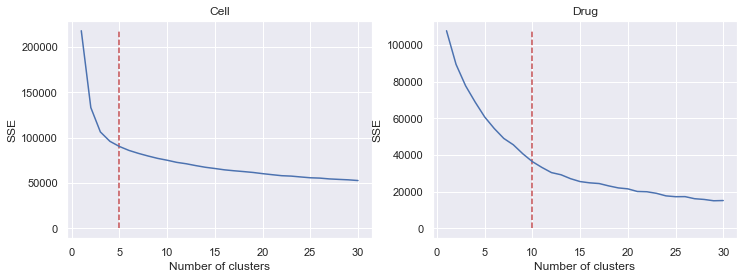

In [21]:
kmeans_cell_svd, sse_cell_svd, silhouette_cell_svd = find_kmeans(mx_svd, kmeans_kwargs)
kmeans_drug_svd, sse_drug_svd, silhouette_drug_svd = find_kmeans(mx_svd.T, kmeans_kwargs)

plot_kmeans(kmeans_cell_svd, kmeans_drug_svd, sse_cell_svd, sse_drug_svd, title='knn_svd')

# Save CSV Files

In [22]:
pd.DataFrame(mx_cell).to_csv("../assets/cell_lrm.csv", index=False)
pd.DataFrame(mx_drug.T).to_csv("../assets/drug_lrm.csv", index=False)

In [26]:
tsne = TSNE(n_components=2, verbose=1)
tsne_cell = tsne.fit_transform(mx_center)
tsne_drug = tsne.fit_transform(mx_center.T)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 809 samples in 0.023s...
[t-SNE] Computed neighbors for 809 samples in 0.208s...
[t-SNE] Computed conditional probabilities for sample 809 / 809
[t-SNE] Mean sigma: 4.888898
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.792793
[t-SNE] KL divergence after 1000 iterations: 1.373412
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.026s...
[t-SNE] Computed neighbors for 198 samples in 0.059s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 9.067174
[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.603188
[t-SNE] KL divergence after 1000 iterations: 0.531991


In [27]:
## create dataframe with cell data
pd.DataFrame({'cell':list_cell, 
              'PC1':mx_cell_pca2[:, 0],
              'PC2':mx_cell_pca2[:, 1],
              'tsne1':tsne_cell[:, 0],
              'tsne2':tsne_cell[:, 1],
              'knn_all':kmeans_cell.labels_,
              'knn_pca':kmeans_cell_pca.labels_,
              'knn_svd':kmeans_cell_svd.labels_,
              'lnIC50_mean':np.nanmean(mx_gdsc, axis=1)}).to_csv("../assets/cell.csv", index=False)

In [28]:
## create dataframe with drug data
temp_list = [re.sub(" \(", "\n", string) for string in list_drug]
temp_list = [re.sub("\)", "", string) for string in temp_list]

pd.DataFrame({'drug':temp_list, 
              'PC1':mx_drug_pca2[:, 0],
              'PC2':mx_drug_pca2[:, 1],
              'tsne1':tsne_drug[:, 0],
              'tsne2':tsne_drug[:, 1],
              'knn_all':kmeans_drug.labels_,
              'knn_pca':kmeans_drug_pca.labels_,
              'knn_svd':kmeans_drug_svd.labels_,
              'lnIC50_mean':np.nanmean(mx_gdsc, axis=0)}).to_csv("../assets/drug.csv", index=False)

# NOT IN USE

In [ ]:
n = 10
idx_top = np.zeros((n, n))
idx_bottom = np.zeros((n, n))

for i in range(n):
    idx_bottom[i, :] = np.argsort(V[:, i])[:n]
    idx_top[i, :] = np.argsort(V[:, i])[-n:]

# print(idx_bottom)
# print()
# print(idx_top)
# print()

# for x in range(n):
#     print("Top factor u{0}".format(x+1))
#     print([U[int(i), x] for i in idx_top[x, :]])
#     print("Bottom factor u{0}".format(x+1))
#     print([U[int(i), x] for i in idx_bottom[x, :]])
#     print()

for x in range(n):
    print("Top drugs factor v{0}".format(x+1))
    print([list_drug[int(i)] for i in idx_top[x, :]])
    print("Bottom drugs factor v{0}".format(x+1))
    print([list_drug[int(i)] for i in idx_bottom[x, :]])
    print()